In [7]:
!pip list

Package                Version
---------------------- ---------
anyio                  3.6.2
argon2-cffi            21.3.0
argon2-cffi-bindings   21.2.0
attrs                  22.1.0
Babel                  2.11.0
backcall               0.2.0
beautifulsoup4         4.11.1
bleach                 5.0.1
brotlipy               0.7.0
cbor                   1.0.0
certifi                2022.6.15
cffi                   1.15.0
chardet                4.0.0
charset-normalizer     2.0.4
chest                  0.2.3
colorama               0.4.4
conda                  4.13.0
conda-build            3.21.9
conda-content-trust    0+unknown
conda-package-handling 1.8.1
cryptography           37.0.1
cwl-eval               1.0.12
cycler                 0.11.0
debugpy                1.6.3
decorator              5.1.1
defusedxml             0.7.1
Deprecated             1.2.13
dill                   0.3.6
dnspython              2.2.1
entrypoints            0.4
fastjsonschema         2.16.2
filelock          

In [5]:
!pip install matplotlib opencv-python

In [6]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from tira_utils import get_input_directory_and_output_directory, normalize_run
import pyterrier as pt
import pandas as pd
import os
import json
from tqdm import tqdm
from glob import glob
from pathlib import Path
from collections import Counter

0it [26:10, ?it/s]


In [7]:
"""def brute_force_surf_matching(image1, image2):
    # Initiate SURF detector
    surf = cv.SURF_create()
    
    image1_gray = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
    image2_gray = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)

    # find the keypoints and descriptors with SURF
    kp1, des1 = surf.detectAndCompute(image1_gray, None)
    kp2, des2 = surf.detectAndCompute(image2_gray, None)
    
    if isinstance(kp1, int) or isinstance(kp2, int):
        return [], 0
    elif len(kp1) == 0 or len(kp2) == 0:
        return [], 0

    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])

    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv.drawMatchesKnn(image1, kp1, image2, kp2, good, None,
                             flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return img3, len(good)"""

def brute_force_orb_matching(image1, image2):
    # Initiate ORB detector
    orb = cv.ORB_create()
    
    image1_gray = cv.cvtColor(image1, cv.COLOR_RGB2GRAY)
    image2_gray = cv.cvtColor(image2, cv.COLOR_RGB2GRAY)

    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(image1_gray, None)
    kp2, des2 = orb.detectAndCompute(image2_gray, None)
    
    if isinstance(kp1, int) or isinstance(kp2, int):
        return [], 0
    elif len(kp1) == 0 or len(kp2) == 0:
        return [], 0

    # BFMatcher with default param
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])

    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv.drawMatchesKnn(image1, kp1, image2, kp2, good, None,
                             flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return img3, len(good)

def brute_force_orb_homography_matching(image1, image2):
    MIN_MATCH_COUNT = 4

    ## Create ORB object and BF object(using HAMMING)
    orb = cv.ORB_create()

    image1_gray = cv.cvtColor(image1, cv.COLOR_RGB2GRAY)
    image2_gray = cv.cvtColor(image2, cv.COLOR_RGB2GRAY)

    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(image1_gray, None)
    kp2, des2 = orb.detectAndCompute(image2_gray, None)

    # BFMatcher with default params
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    if len(good)>MIN_MATCH_COUNT:
        ## extract the matched keypoints
        src_pts  = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
        dst_pts  = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

        ## find homography matrix and do perspective transform
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        h,w = image1.shape[:2]
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts,M)
    
     # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv.drawMatches(image1, kp1, image2, kp2, good, None,
                             flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return img3, len(good)

# not working with ORB
def flann_index_kdtree_matcher(image1, image2):
    MIN_MATCH_COUNT = 10
    
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    
    image1_gray = cv.cvtColor(image1, cv.COLOR_RGB2GRAY)
    image2_gray = cv.cvtColor(image2, cv.COLOR_RGB2GRAY)

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(image1_gray, None)
    kp2, des2 = sift.detectAndCompute(image2_gray, None)
    
    if des1 is None or des2 is None:
        return [], 0
            
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    # Apply ratio test
    global good
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
            
    most_common_keypoint_matches = Counter(x.trainIdx for x in good).most_common(1)[0]
    
    # single keypoint check for to many matches
    if most_common_keypoint_matches[1] > 10:
        return [], 0
            
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        
        if M is None:
            print("empty Homography on image")
            return [], 0
        
        matchesMask = mask.ravel().tolist()
        
        h,w, _ = image1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts,M)
        image2 = cv.polylines(image2,[np.int32(dst)],True,255,3, cv.LINE_AA)
             
    else:
        # print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=(255, 0, 0),
                       matchesMask=matchesMask,
                       flags=cv.DrawMatchesFlags_DEFAULT)
    
    img_matches = np.empty((max(image1.shape[0], image2.shape[0]), image1.shape[1]+image2.shape[1], 3), dtype=np.uint8)
    # img3 = cv.drawMatches(image1, kp1, image2, kp2, good, img_matches, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    img3 = cv.drawMatches(image1, kp1, image2, kp2, good, img_matches, **draw_params)
    
    # plt.imshow(img3, ), plt.show()
    
    return img3, len(good)

In [51]:
%%time
import glob

# image_paths = glob.glob('dataset22/images/I0[0-9]/*/image.webp')
image_paths = glob.glob('dataset22/images/I0*/*/image.webp')
# image_paths = glob.glob('dataset22/images/*/*/image.webp')

CPU times: user 516 ms, sys: 292 ms, total: 808 ms
Wall time: 4.11 s


In [52]:
image_paths

['dataset22/images/I00/I000330ba4ea0ad13/image.webp',
 'dataset22/images/I00/I000d8de9c4746ee9/image.webp',
 'dataset22/images/I00/I0010d5b5473065fa/image.webp',
 'dataset22/images/I00/I001652ec040f07c4/image.webp',
 'dataset22/images/I00/I001a318b3176d501/image.webp',
 'dataset22/images/I00/I001b3068979b8629/image.webp',
 'dataset22/images/I00/I001c2de5ef28f77f/image.webp',
 'dataset22/images/I00/I001d567f0fb443d7/image.webp',
 'dataset22/images/I00/I00246a6916fec768/image.webp',
 'dataset22/images/I00/I0024c0097c425855/image.webp',
 'dataset22/images/I00/I002747d3611b43da/image.webp',
 'dataset22/images/I00/I0027bcd7cd6938d9/image.webp',
 'dataset22/images/I00/I00290a8d0fe34013/image.webp',
 'dataset22/images/I00/I002959a3418da38a/image.webp',
 'dataset22/images/I00/I002d16483c9a4e26/image.webp',
 'dataset22/images/I00/I002dd0599859cb69/image.webp',
 'dataset22/images/I00/I002e942703b3e786/image.webp',
 'dataset22/images/I00/I003811155228eb5d/image.webp',
 'dataset22/images/I00/I003a

In [6]:
len(image_paths)

1471

In [6]:
(len(image_paths) // 10) * 2

4768

In [6]:
%%time
less_image_paths = image_paths[:(len(image_paths) // 10) * 1]
# images = [cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB) for image_path in less_image_paths]
images = [cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB) for image_path in image_paths]

CPU times: user 27.2 s, sys: 12.5 s, total: 39.7 s
Wall time: 48.5 s


In [54]:
most_common_query = Counter(x.queryIdx for x in good).most_common(1)[0]
most_common_train = Counter(x.trainIdx for x in good).most_common(1)[0]
most_common_train

(123, 17)

In [28]:
m,n

(3, 2144)

In [51]:
img1 = cv.imread("image_results/topic_generated.png")
img2 = images[312]
img3 = images[2]
# Displaying the image
# cv.imshow('image', img)
    
pair1_img, pair1_match_len = flann_index_kdtree_matcher(img1, img2)
# pair1_img, pair1_match_len = bf_sift_homography_matcher(img1, img2)
# pair1_img, pair1_match_len = brute_force_orb_homography_matching(img1, img2)

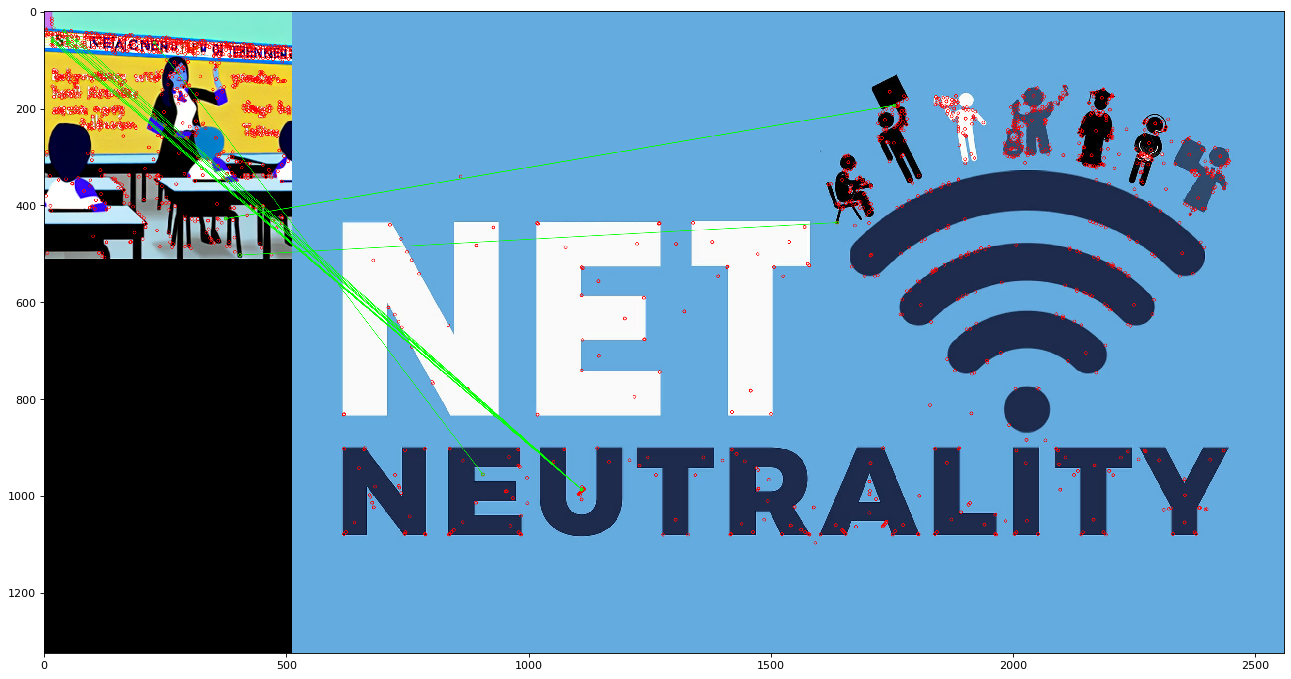

In [52]:
fig = plt.figure(figsize=(20, 20), dpi=80)
ax = fig.add_subplot(111)

ax.imshow(pair1_img, interpolation='nearest')

plt.show()

In [8]:
img1 = cv.UMat(images[0])
img2 = cv.UMat(images[1])

%time pair1_img, pair1_good_matches = brute_force_sift_matching(img1, img2)

CPU times: user 6.54 s, sys: 1.4 s, total: 7.94 s
Wall time: 2.35 s


In [ ]:
pair2_img, pair2_good_matches = brute_force_sift_matching_cuda(img1, img3)
# cv.imshow('image', pair2_img)

In [2]:
from preselection import retrieve

I will use a small hardcoded example located in /workspace/dataset22/.
The output directory is /tmp/



0it [00:00, ?it/s]
1it [00:00,  1.16it/s]
3it [00:00,  3.72it/s]
7it [00:01,  4.60it/s]
9it [00:01,  6.07it/s]
12it [00:01,  8.96it/s]
16it [00:02, 13.56it/s]
20it [00:02, 17.61it/s]
24it [00:02, 21.26it/s]
27it [00:02, 22.16it/s]
31it [00:02, 24.80it/s]
35it [00:02, 27.28it/s]
39it [00:02, 28.87it/s]
43it [00:02, 30.45it/s]
47it [00:03, 31.82it/s]
51it [00:03, 31.65it/s]
55it [00:03, 32.81it/s]
59it [00:03, 34.46it/s]
63it [00:03, 33.92it/s]
67it [00:03, 32.87it/s]
71it [00:03, 33.92it/s]
75it [00:03, 34.03it/s]
79it [00:03, 34.11it/s]
83it [00:04, 34.05it/s]
88it [00:04, 36.44it/s]
92it [00:04, 36.41it/s]
96it [00:04, 32.98it/s]
100it [00:04, 33.37it/s]
104it [00:04, 34.52it/s]
108it [00:04, 35.26it/s]
112it [00:04, 35.08it/s]
116it [00:05, 34.43it/s]
120it [00:05, 33.36it/s]
124it [00:05, 34.26it/s]
129it [00:05, 36.69it/s]
133it [00:05, 36.62it/s]
137it [00:05, 35.22it/s]
141it [00:05, 33.91it/s]
145it [00:05, 32.52it/s]
149it [00:06, 31.30it/s]
153it [00:06, 31.41it/s]
157it [00:

16:12:28.591 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (I47e296f116f4c218) - further warnings are suppressed



6754it [03:57, 18.26it/s]
6759it [03:57, 22.80it/s]
6764it [03:57, 27.19it/s]
6768it [03:58, 29.14it/s]
6772it [03:58, 30.89it/s]
6776it [03:58, 31.44it/s]
6780it [03:58, 31.43it/s]
6784it [03:58, 30.51it/s]
6788it [03:58, 30.40it/s]
6792it [03:58, 31.68it/s]
6796it [03:59, 21.72it/s]
6800it [03:59, 24.59it/s]
6804it [03:59, 26.76it/s]
6808it [03:59, 28.80it/s]
6812it [03:59, 30.49it/s]
6817it [03:59, 34.24it/s]
6821it [03:59, 33.54it/s]
6825it [03:59, 33.43it/s]
6829it [04:00, 32.99it/s]
6833it [04:00, 33.01it/s]
6837it [04:00, 33.85it/s]
6842it [04:00, 37.08it/s]
6846it [04:00, 25.40it/s]
6850it [04:00, 27.81it/s]
6854it [04:00, 29.66it/s]
6858it [04:01, 31.31it/s]
6862it [04:01, 31.76it/s]
6866it [04:01, 32.01it/s]
6870it [04:01, 32.50it/s]
6874it [04:01, 32.41it/s]
6878it [04:01, 32.60it/s]
6882it [04:01, 33.12it/s]
6886it [04:01, 32.86it/s]
6890it [04:02, 32.39it/s]
6894it [04:02, 31.83it/s]
6898it [04:02, 31.51it/s]
6902it [04:02, 31.73it/s]
6906it [04:02, 31.27it/s]
6910it [04:

16:21:22.407 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Indexed 2 empty documents


In [8]:
def load_queries():
    file_name = 'dataset22/topics.xml'
    
    if not os.path.exists(file_name):
        raise ValueError(f'Could not find the file "{file_name}". Got: {glob(input_directory + "/*")}')
    
    topics = pd.read_xml(file_name)
    
    ret = pd.DataFrame()
    # https://github.com/terrier-org/pyterrier/issues/62\n",
    ret['query'] = topics['title'].apply(lambda i: "".join([x if x.isalnum() else " " for x in i]))
    ret['qid'] = topics['number']
    return ret

queries = load_queries()  
queries.iloc[[0]]

,query,qid
0,Should teachers get tenure,1


In [9]:
preselection_data = retrieve(queries.iloc[[0]])

BR(BM25): 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44q/s]


In [10]:
preselection_data

,qid,docid,docno,rank,score,query
0,1,11358,I79c8a4b26897a4ed,0,16.310421,Should teachers get tenure
1,1,14432,I9b25ecf576b9b5f6,1,16.292609,Should teachers get tenure
2,1,16916,Ib677e76f7eb8ee65,2,16.292609,Should teachers get tenure
3,1,17051,Ib7fc7d5f8ee59d62,3,16.292609,Should teachers get tenure
4,1,22834,If50e077aa7bd9d73,4,16.281629,Should teachers get tenure
5,1,21187,Ie3a2a096e79de329,5,16.275743,Should teachers get tenure
6,1,987,I0b183549ed98b99b,6,16.275503,Should teachers get tenure
7,1,20321,Ida38cedbe37cc3d8,7,16.272265,Should teachers get tenure
8,1,15427,Ia5cf018853aab60e,8,16.269102,Should teachers get tenure
9,1,20129,Id82aa7d9f1940caa,9,16.259286,Should teachers get tenure


In [42]:
preselection_data["docno"]

0     I79c8a4b26897a4ed
1     I9b25ecf576b9b5f6
2     Ib677e76f7eb8ee65
3     Ib7fc7d5f8ee59d62
4     If50e077aa7bd9d73
5     Ie3a2a096e79de329
6     I0b183549ed98b99b
7     Ida38cedbe37cc3d8
8     Ia5cf018853aab60e
9     Id82aa7d9f1940caa
10    I8d004823a81b0abb
11    Id6cd8e8f29a3bff7
12    I9e60517c2520ebe5
13    Id5b5bf693e46c7a3
14    Idfa7b86b286b5030
15    If70b045f8da68fda
16    I31e4c262325e9018
17    I3679e05b8a5055dc
18    Ib19605278b67647e
19    I5d745976b5719c3e
20    Ic95772fd299689f4
21    I72f92221cbde52e1
22    Ic1ac4c1524f51af4
23    I2bf9732a499fe550
24    I6c6b3140e0b6b982
25    I77ceee629f14cd26
26    I86a56f43c8d34d56
27    Id532db799e1662f1
28    Idb6c2f6c89d37f2f
29    If6e4adc81569f005
30    I8411351458258043
31    I3f3eae576f922a3b
32    I7f0e98217b82986b
33    I2dda022878455420
34    Ia69b3c0aa45805c4
35    I11b56cbf3280848f
36    Idaed25dffed1f841
37    I7a506c5d4fbaf593
38    I3285da4fa58019de
39    I83318452230d3366
40    I3541cb8d28153c5c
41    Id10e1d884

In [11]:
def load_image_paths(image_ids):
    image_paths = []
    
    for image_id in image_ids:
        image_paths.append('dataset22/images/' + image_id[:3] + '/' + image_id + '/image.webp')
        
    return image_paths

image_paths = load_image_paths(preselection_data["docno"])
print(image_paths[0])
images = [cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB) for image_path in image_paths]

dataset22/images/I79/I79c8a4b26897a4ed/image.webp


In [15]:
images[0]

447

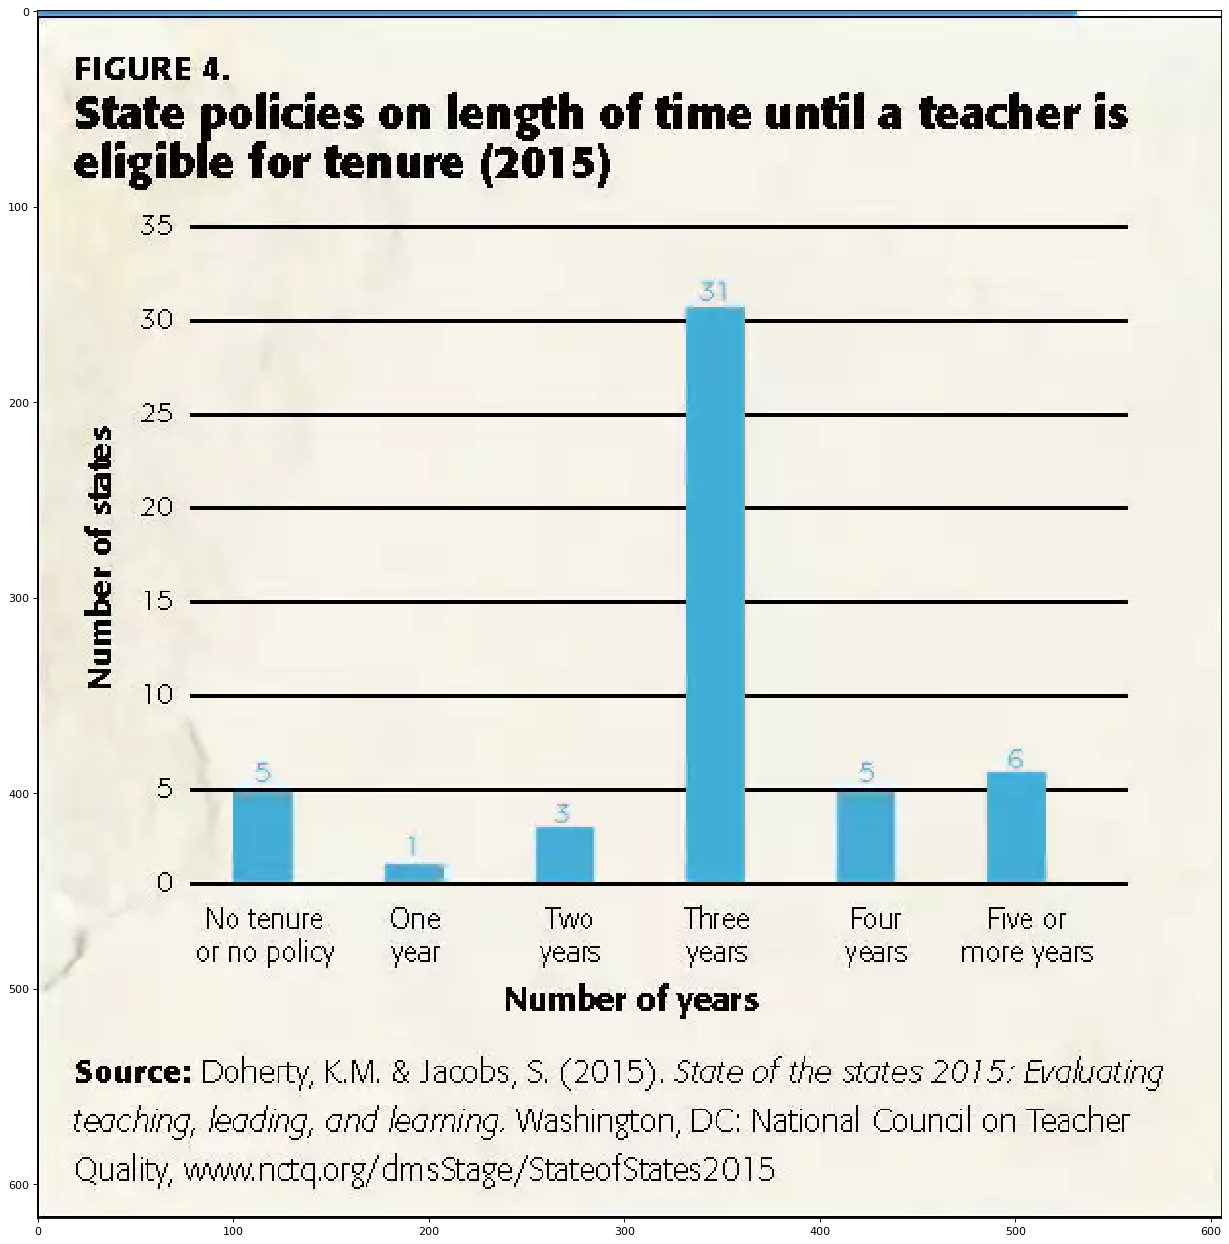

In [23]:
fig = plt.figure(figsize=(20, 20), dpi=80)
ax = fig.add_subplot(111)

ax.imshow(images[1], interpolation='nearest')
# ax.set_aspect(5)

# plt.imshow(img3, random. rand(8, 90)), 
plt.show()

In [12]:
%%time
topic_img = cv.cvtColor(cv.imread("image_results/topic_generated.png"), cv.COLOR_BGR2RGB)
# topic_img = cv.UMat(cv.imread("image_results/topic_generated.png"))
best_match_img = []
highest_match_count = 0
highest_img_num = 0
img_num = 0

CPU times: user 20.2 ms, sys: 849 µs, total: 21.1 ms
Wall time: 49.8 ms


In [18]:
for image in images:
    # umat_image = cv.UMat(image)
    
    if image.size <= 100000000:
        print(img_num)
        # img, good_matches = brute_force_orb_matching(topic_img, image)
        # img, good_matches = brute_force_orb_homography_matching(topic_img, image)
        img, good_matches = flann_index_kdtree_matcher(topic_img, image)
        # img, good_matches = brute_force_orb_matching(topic_img, umat_image)
        
        """print(type(good_matches))
        if type(good_matches) == int:
            print("int:" + str(good_matches))
        else:
            print("Matches: " + str(len(good_matches)))"""
            
        print("Matches: " + str(good_matches))
        print("----")
        
        if highest_match_count < good_matches:
            best_match_img = img
            highest_img_num = img_num
            highest_match_count = good_matches
    
    img_num += 1

[[[226 178  51]
  [226 178  51]
  [226 178  51]
  ...
  [ 41  38  53]
  [ 38  36  51]
  [ 35  33  47]]

 [[224 176  51]
  [224 176  51]
  [224 176  51]
  ...
  [ 37  35  49]
  [ 35  33  47]
  [ 33  30  45]]

 [[221 173  50]
  [221 173  50]
  [221 173  50]
  ...
  [ 35  33  47]
  [ 33  30  45]
  [ 31  29  44]]

 ...

 [[108 151 114]
  [127 167 131]
  [146 185 147]
  ...
  [ 63  41  51]
  [ 77  53  59]
  [ 87  62  66]]

 [[107 150 113]
  [127 167 131]
  [146 185 147]
  ...
  [ 62  42  51]
  [ 76  55  60]
  [ 86  63  66]]

 [[107 150 113]
  [127 167 131]
  [146 185 147]
  ...
  [ 57  44  51]
  [ 73  56  60]
  [ 81  65  66]]]
--------------------------
0
Matches: 28
----
[[[ 68 137 217]
  [ 68 137 217]
  [ 68 137 217]
  ...
  [251 250 243]
  [251 250 243]
  [251 250 243]]

 [[ 85 149 216]
  [ 85 149 216]
  [ 82 147 214]
  ...
  [255 255 249]
  [255 255 249]
  [255 255 249]]

 [[105 158 199]
  [105 158 199]
  [106 159 200]
  ...
  [252 251 244]
  [252 251 244]
  [252 251 244]]

 ...

 [[  9

AttributeError: 'list' object has no attribute 'size'

In [ ]:
"""
UMAT:   CPU times: user 57.3 s, sys: 24.5 s, total: 1min 21s
        Wall time: 26.2 s

Normal: CPU times: user 55.1 s, sys: 24.7 s, total: 1min 19s
        Wall time: 25.4 s

"""

In [56]:
print(highest_match_count)
print(highest_img_num)
print(img_num)

67
45
50


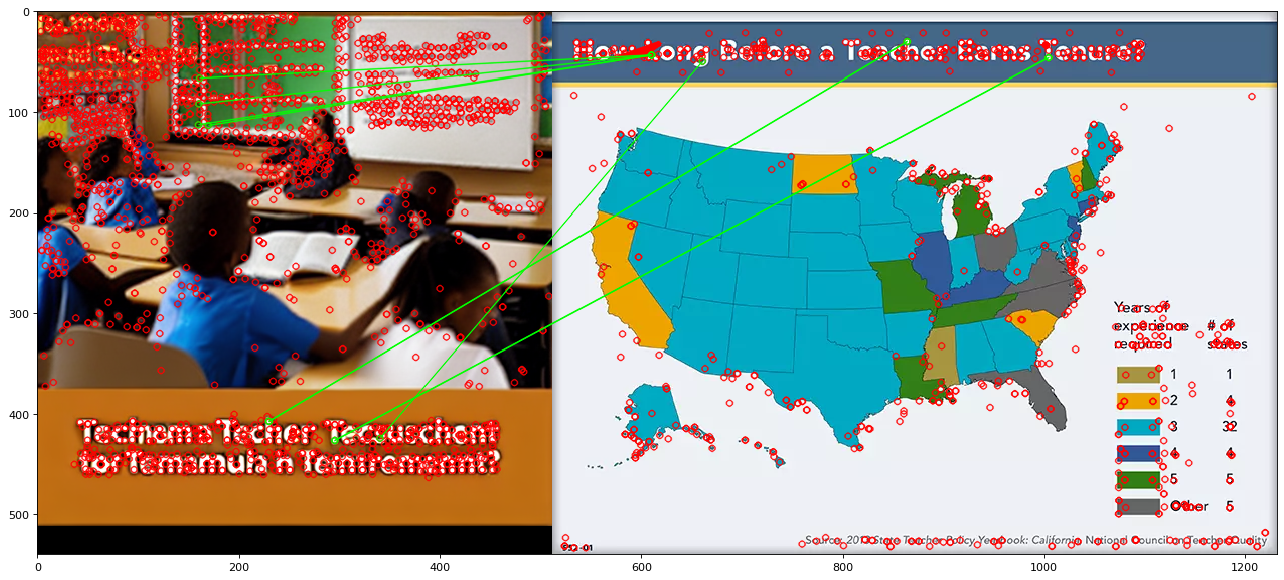

In [57]:
fig = plt.figure(figsize=(20, 20), dpi=80)
ax = fig.add_subplot(111)

ax.imshow(best_match_img, interpolation='nearest')
# ax.set_aspect(5)

# plt.imshow(img3, random. rand(8, 90)), 
plt.show()

In [28]:
def sort_images(images, dataframe):
    sorted_images = []
    
    for i in range(len(images)):
        image_id = dataframe["image_id"][i]
        sorted_images.append(images[image_id])
    
    return sorted_images

def get_sorted_images(images):
    topic_img = cv.cvtColor(cv.imread("image_results/topic_generated.png"), cv.COLOR_BGR2RGB)
    image_ids = []
    match_numbers = []
    img_num = 0

    for image in images:
        # print(img_num)
    
        if image.size <= 100000000:
            img, good_matches = flann_index_kdtree_matcher(topic_img, image)
        
            image_ids.append(img_num)
            match_numbers.append(good_matches)
    
        img_num += 1

    matched_images_dataframe = pd.DataFrame({"image_id": image_ids, "match_num": match_numbers})
    sorted_matched_images_dataframe = matched_images_dataframe.sort_values(by=['match_num'], ascending=False).reset_index(drop=True)
    
    sorted_images = sort_images(images, sorted_matched_images_dataframe)

In [ ]:
def show_multiple_images(image_list, row_count, col_count):
    for i in range(0, len(image_list), row_count*col_count):
        fig = plt.figure(figsize=(20, 120), dpi=80)
    
    for j in range(0, row_count*col_count):
        fig.add_subplot(row_count, col_count, j+1)
        plt.imshow(image_list[i+j])
    plt.show()

sorted_images = get_sorted_images(images)
show_multiple_images(sorted_images, 25, 2)

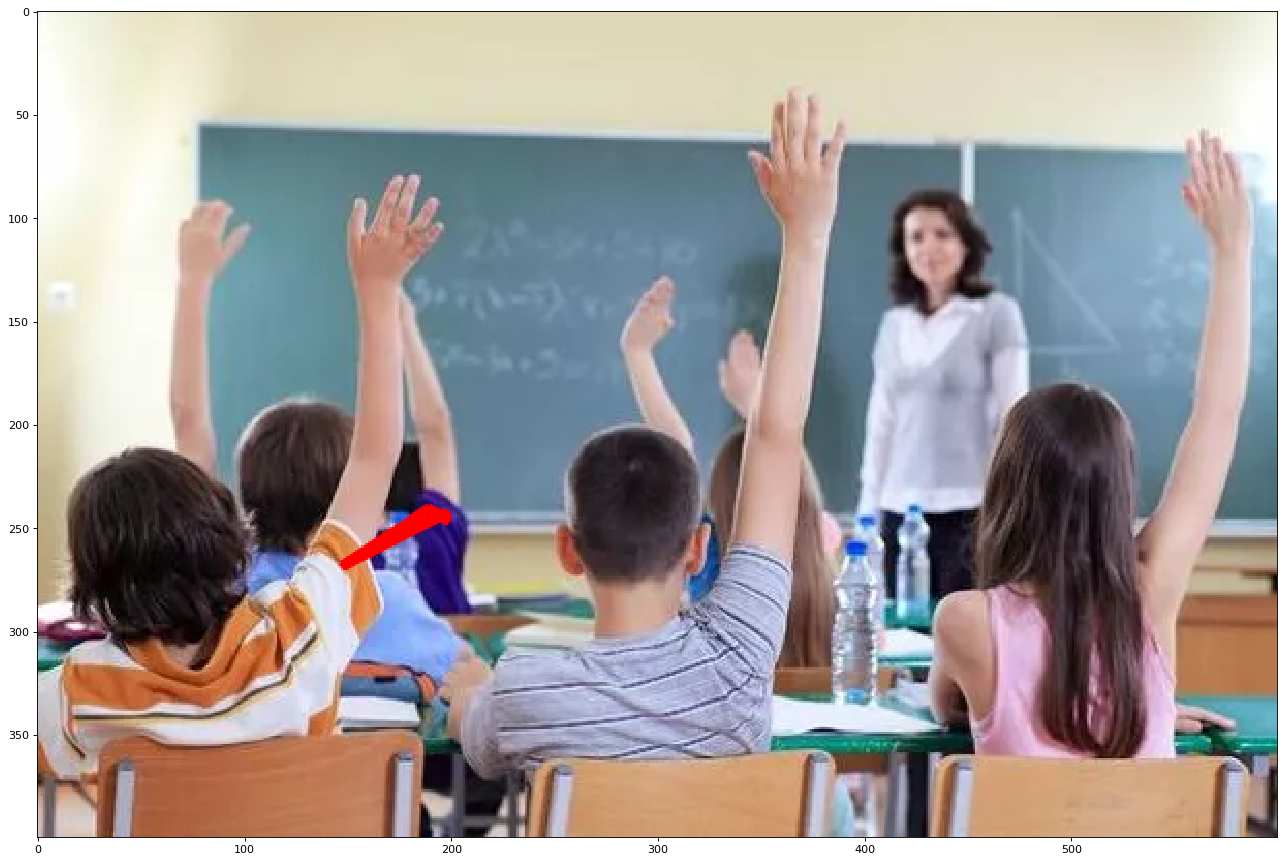

In [25]:
fig = plt.figure(figsize=(20, 20), dpi=80)
ax = fig.add_subplot(111)

ax.imshow(sorted_images[1], interpolation='nearest')
# ax.set_aspect(5)

# plt.imshow(img3, random. rand(8, 90)), 
plt.show()

In [49]:
topic_xml_data = open('dataset22/topics.xml', 'r').read() 

topics_dataframe = pd.read_xml(topic_xml_data)
topics_dataframe

,number,title,description,narrative
0,1,Should teachers get tenure?,A user has heard that some countries do give t...,Highly relevant arguments make a clear stateme...
1,2,Is vaping with e-cigarettes safe?,When considering to switch from smoking to vap...,Highly relevant arguments support or deny the ...
2,3,Should insider trading be allowed?,"Since many marketplaces are liberalized, the u...",Highly relevant arguments argue for or against...
3,4,Should corporal punishment be used in schools?,Discipline in schools is associated with bette...,Highly relevant arguments include ones that ar...
4,5,Should social security be privatized?,"The costs of social security are enormous, and...",Highly relevant arguments take the pro or con ...
5,6,Is a college education worth it?,A lot of educational resources can be found on...,Highly relevant arguments make a statement on ...
6,7,Should felons who have completed their sentenc...,People who committed a serious crime have posi...,Highly relevant arguments consider reasons for...
7,8,Should abortion be legal?,It is an open question at what point human lif...,Highly relevant arguments take a stance for or...
8,9,Should students have to wear school uniforms?,"Promoting equality is a key goal at school, an...",Highly relevant arguments consider the benefit...
9,10,Should any vaccines be required for children?,"Anti-vaccination movements are on the rise, an...",Highly relevant arguments name one or more vac...


In [44]:
topics_dataframe['title'].head(5)

0                       Should teachers get tenure?
1                 Is vaping with e-cigarettes safe?
2                Should insider trading be allowed?
3    Should corporal punishment be used in schools?
4             Should social security be privatized?
Name: title, dtype: object

In [48]:
topics_dataframe.iloc[0]['description']

"A user has heard that some countries do give teachers tenure and others don't. Interested in the reasoning for or against tenure, the user searches for positive and negative arguments. The situation of school teachers vs. university professors is of interest."